# 2022-10-14 Preconditioning

## Last time

* Krylov methods (focus on GMRES)
* PETSc experiments
* Simple preconditioners

## Today
* Preconditioning building blocks
* Domain decomposition
* PETSc discussion

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Simple preconditioners

## Jacobi `-pc_type jacobi`

$$ P_{\text{Jacobi}}^{-1} = D^{-1} $$
where $D$ is the diagonal of $A$.

## Gauss-Seidel `-pc_type sor`

$$ P_{GS}^{-1} = (L+D)^{-1} $$
where $L$ is the (strictly) lower triangular part of $A$.  The upper triangular part may be used instead, or a symmetric form
$$ P_{SGS}^{-1} = (L+U)^{-1} A \Big( I - (L+D)^{-1} \Big) . $$

### Over-relaxation

`-pc_sor_omega 1.` is default (Gauss-Seidel)

## Run p-Laplacian example
```console
$ cd src/snes/tutorials
$ make ex15
$ ./ex15 -da_refine 2 -dm_view
$ ./ex15 -ksp_monitor -pc_type jacobi
$ ./ex15 -snes_view
```

## Experiments

* How does iteration count vary under grid refinement?
* How sensitive is it to parameters
  * p-Laplacian `-p` $> 1$ and `-epsilon` $> 0$
  * Bratu `-lambda` $< 6.8$
* How sensitive to `-ksp_gmres_restart`?
* `-ksp_monitor_true_residual`
* `-ksp_view_eigenvalues`

# Incomplete factorization

* Start factoring like in a sparse direct solver
  * **ILU(0)** Discard fill outside the sparsity pattern of $A$
  * **ILU($k$)**: only allow $k$ levels of fill
  * **ILUT($\epsilon$)**: only keep fill values larger than $\epsilon$

## Experiments
* Try `-pc_factor_levels 2`
* Impact on cost (check `-log_view`)
* Impact on scalability (`-da_refine 6`)

## Kershaw (1978) matrix

Incomplete Cholesky can break down for SPD matrices.

```console
$ make $PETSC_ARCH/tests/ksp/pc/tutorials/ex1
```
and try running.

In [57]:
K = [3 -2 0 2; -2 3 -2 0; 0 -2 3 -2; 2 0 -2 3]
eigvals(K)

4-element Vector{Float64}:
 0.17157287525380904
 0.17157287525381085
 5.828427124746186
 5.82842712474619

# Domain decomposition

![](https://upload.wikimedia.org/wikipedia/commons/a/a9/Ddm_original_logo.png)

## Alternating Schwarz method
```python
bc_circ = guess()
while not converged:
    u_circ = solve(A_circ, bc_circ)
    bc_rect = eval(u_circ, rect)
    u_rect = solve(A_rect, bc_rect)
    bc_circ = eval(u_rect, circ)
```

This method was proposed in 1870 by [Hermann Schwarz](https://en.wikipedia.org/wiki/Hermann_Schwarz) as a theoretical tool, and is now called a **multiplicative** Schwarz method because the solves depend on each other.  We can see it as a generalization of Gauss-Seidel in which we solve on subdomains instead of at individual grid points.  As with Gauss-Seidel, it is difficult to expose parallelism.

# Additive Schwarz

The additive Schwarz method is more comparable to Jacobi, with each domain solved in parallel.  Our fundamental operation will be an embedding of each subdomain $V_i$ into the global domain $V$, which we call the **prolongation**

$$ P_i : V_i \to V $$

The transpose of prolongation, $P_i^T$, will sometimes be called **restriction**.
Let's work an example.

In [59]:
n = 21
x = LinRange(-1, 1, n)
overlap = 0
domains = [(1, n÷3), (n÷3+1, 2*n÷3), (2*n÷3+1, n)]
Id = diagm(ones(n))
P = []
for (i, (left, right)) in enumerate(domains)
    push!(P, Id[:, left:right])
end

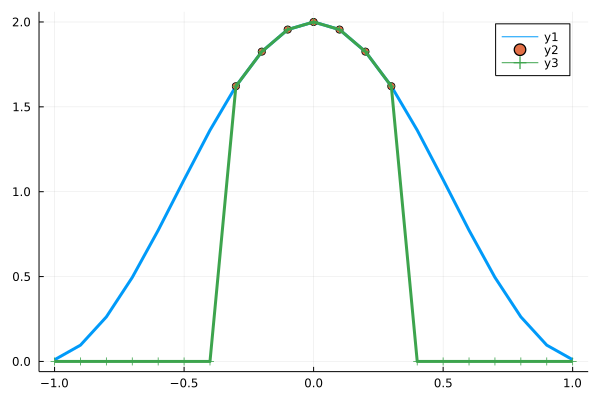

In [61]:
u = 1 .+ cos.(3*x)
plot(x, u)
u_2 = P[2]' * u
scatter!(P[2]' * x, u_2)
plot!(x, P[2] * u_2, marker=:auto)

# The algorithm

Define the subdomain operator $$A_i = P_i^T A P_i$$
The additive Schwarz preconditioner is
$$ M^{-1} = \sum_i P_i A_i^{-1} P_i^T $$
and it has error iteration matrix
$$ I - \sum_i  P_i A_i^{-1} P_i^T A $$

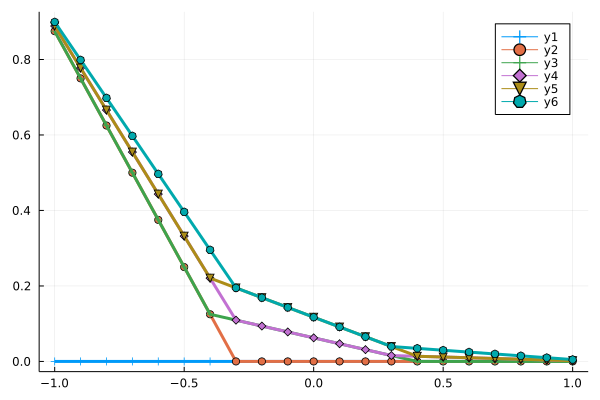

In [64]:
A = diagm(0 => 2*ones(n), -1 => -ones(n-1), 1 => -ones(n-1))
b = zeros(n); b[1] = 1
u = zero(b) # initial guess
us = [u]
for _ in 1:5
    r = b - A * u # residual
    u_next = copy(u);
    for Pi in P
        Ai = Pi' * A * Pi
        ui = Ai \ (Pi' * r)
        u_next += Pi * ui
    end
    u = u_next; push!(us, u)
end
plot(x, us, marker=:auto)

# Theory
Given a linear operator $A : V \to V$, suppose we have a collection of prolongation operators $P_i : V_i \to V$.  The columns of $P_i$ are "basis functions" for the subspace $V_i$.  The Galerkin operator $A_i = P_i^T A P_i$ is the action of the original operator $A$ in the subspace.

Define the subspace projection

$$ S_i = P_i A_i^{-1} P_i^T A . $$

* $S_i$ is a projector: $S_i^2 = S_i$
* If $A$ is SPD, $S_i$ is SPD with respect to the $A$ inner product $x^T A y$
* $I - S_i$ is $A$-orthogonal to the range of $P_i$

In [6]:
A2 = P[2]' * A * P[2]
S2 = P[2] * inv(A2) * P[2]' * A
norm(S2^2 - S2)

1.2036131040197588e-15

In [7]:
norm(P[2]' * A * (I - S2))

1.1831170202396054e-15

**Note:** The concept of $A$-orthogonality is meaningful only when $A$ is SPD.
Does the mathematical expression $ P_i^T A (I - S_i) = 0 $ hold even when $A$ is nonsymmetric?

# Convergence theory

The formal convergence is beyond the scope of this course, but the following estimates are useful.  We let $h$ be the element diameter, $H$ be the subdomain diameter, and $\delta$ be the overlap, each normalized such that the global domain diameter is 1.  We express the convergence in terms of the condition number $\kappa$ for the preconditioned operator.

* (Block) Jacobi: $\delta=0$, $\kappa \sim H^{-2} H/h = (Hh)^{-1}$
* Overlapping Schwarz: $\kappa \sim H^{-2} H/\delta = (H \delta)^{-1}$
* 2-level overlapping Schwarz: $\kappa \sim H/\delta$

* Additive $ I - \sum_{i=0}^n S_i, $

* Multiplicative $ \prod_{i=0}^n (I - S_i), $
* Hybrid $ (I - S_0) (I - \sum_{i=1}^n S_i) . $

In each case above, the action is expressed in terms of the error iteration operator.

# PETSc experiments

* Compare domain decomposition and multigrid preconditioning
 * `-pc_type asm` (Additive Schwarz)
  * `-pc_asm_type basic` (symmetric, versus `restrict`)
  * `-pc_asm_overlap 2` (increase overlap)
  * Effect of direct subdomain solver: `-sub_pc_type lu`

* Symmetric example: `src/snes/examples/tutorials/ex5.c`
* Nonsymmetric example: `src/snes/examples/tutorials/ex19.c`
* Compare preconditioned versus unpreconditioned norms.
* Compare BiCG versus GMRES
 * `-pc_type mg` (Geometric Multigrid)
* Use monitors:
 * `-ksp_monitor_true_residual`
 * `-ksp_monitor_singular_value`
 * `-ksp_converged_reason`
* Explain methods: `-snes_view`
* Performance info: `-log_view`